In [1]:
import os

os.chdir('/home/adeel/world-bank-rai-toolkit/')
os.path.realpath(os.curdir)

'/home/adeel/world-bank-rai-toolkit'

In [2]:
import rasterio
import rasterio.mask
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import numpy as np

/home/adeel/anaconda3/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
pfix = "py"
code = "PRY"
cname = "paraguay"

# pfix = "gt"
# code = "GTM"
# cname = "guatemala"

In [4]:
# Load GADM admin level 1 boundaries
gadm = gpd.read_file(
    f"data/inputs/gadm36_{code}.gpkg", layer=f'gadm36_{code}_1')

# %% Load WorldPop
worldpop = rasterio.open(f"data/inputs/{code.lower()}_ppp_2020.tif", nodata=0)
worldpop_rural = rasterio.open(
    f"data/{code}/{code}_worldpop_rural.tif", nodata=0)
worldpop_rai = rasterio.open(
    f"data/{code}/{code}_worldpop_rai.tif", nodata=0)

In [14]:
worldpop_img = worldpop.read(1)
worldpop_rural_img = worldpop_rural.read(1)
worldpop_rai_img = worldpop_rai.read(1)

worldpop_img.shape, worldpop_rural_img.shape, worldpop_rai_img.shape

((9978, 10065), (9978, 10065), (9978, 10065))

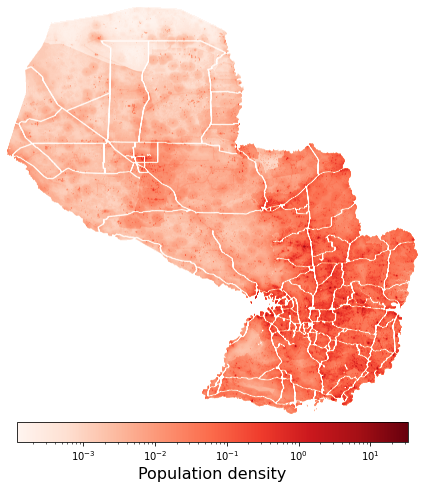

In [6]:
fig = plt.figure(figsize=(8, 8))
plt.imshow(worldpop_img.clip(min=0), norm=colors.LogNorm(), cmap='Reds')
plt.colorbar(fraction=0.045, pad=0.02, orientation='horizontal')
cax = fig.axes[1]
cax.set_xlabel('Population density', fontsize=16)
plt.axis('off')
plt.show()

In [36]:
# Mask function
def add_rai(row):
    region = row['geometry']
    mask = rasterio.mask.geometry_mask([region], out_shape=worldpop_img.shape, transform=worldpop.transform, invert=True)
    pop_img = worldpop_img[mask]
    rural_pop_img = worldpop_rural_img[mask]
    unserved_pop_img = worldpop_rai_img[mask]

    pop = pop_img[pop_img >= 0].sum()
    rural_pop = rural_pop_img[rural_pop_img >= 0].sum()
    unserved_pop = unserved_pop_img[unserved_pop_img >= 0].sum()
    rai = (rural_pop - unserved_pop) / rural_pop

    row['rai'] = rai
    row['population'] = int(pop.round())
    row['population_rural'] = int(rural_pop.round())
    row['population_unserved'] = int(unserved_pop.round())
    return row

In [37]:
rai_df = gadm.apply(add_rai, axis=1)
rai_df

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry,rai,population,population_rural,population_unserved
0,PRY,Paraguay,PRY.1_1,Alto Paraguay,None,None,Departamento,Department,None,PY.AG,"MULTIPOLYGON (((-59.19755 -22.10217, -59.21493...",0.107841,18676,18214,16250
1,PRY,Paraguay,PRY.2_1,Alto Paraná,None,None,Departamento,Department,None,PY.AA,"MULTIPOLYGON (((-54.91671 -26.21915, -54.91685...",0.460257,891778,264248,142626
2,PRY,Paraguay,PRY.3_1,Amambay,None,None,Departamento,Department,None,PY.AM,"MULTIPOLYGON (((-56.02569 -23.82069, -56.00888...",0.196087,178900,80967,65090
3,PRY,Paraguay,PRY.4_1,Asunción,None,None,Distrito Capital,Capital District,None,PY.AS,"MULTIPOLYGON (((-57.58342 -25.33283, -57.58436...",0.875359,532209,47812,5959
4,PRY,Paraguay,PRY.5_1,Boquerón,None,None,Departamento,Department,None,PY.BQ,"MULTIPOLYGON (((-61.85152 -23.10835, -61.85355...",0.282610,69657,56140,40274
5,PRY,Paraguay,PRY.6_1,Caaguazú,None,None,Departamento,Department,None,PY.CG,"MULTIPOLYGON (((-55.43090 -25.53945, -55.43478...",0.336337,571517,351266,233122
6,PRY,Paraguay,PRY.7_1,Caazapá,None,None,Departamento,Department,None,PY.CZ,"MULTIPOLYGON (((-56.66114 -26.72141, -56.66152...",0.419434,191739,156129,90643
7,PRY,Paraguay,PRY.8_1,Canindeyú,None,None,Departamento,Department,None,PY.CY,"MULTIPOLYGON (((-55.13984 -24.49315, -55.14233...",0.410614,258214,211556,124688
8,PRY,Paraguay,PRY.9_1,Central,None,None,Departamento,Department,None,PY.CE,"MULTIPOLYGON (((-57.39828 -25.62112, -57.39888...",0.692106,2329797,70598,21737
9,PRY,Paraguay,PRY.10_1,Concepción,None,None,Departamento,Department,None,PY.CN,"MULTIPOLYGON (((-57.16674 -23.47019, -57.17165...",0.471353,255294,161104,85167


In [40]:
100 * (1 - rai_df.population_unserved.sum() / rai_df.population_rural.sum())

43.30567365879057

In [41]:
out_csv_path = f"data/{code}/{pfix}_population_stats.csv"
out_df = rai_df[[
    'NAME_1', 'rai', 'population', 'population_rural', 'population_unserved'
]].rename(mapper={'NAME_1': 'name'}, axis='columns')
out_df.to_csv(out_csv_path, index=False)

In [42]:
out_df.style.hide_index()


name,rai,population,population_rural,population_unserved
Alto Paraguay,0.107841,18676,18214,16250
Alto Paraná,0.460257,891778,264248,142626
Amambay,0.196087,178900,80967,65090
Asunción,0.875359,532209,47812,5959
Boquerón,0.282610,69657,56140,40274
Caaguazú,0.336337,571517,351266,233122
Caazapá,0.419434,191739,156129,90643
Canindeyú,0.410614,258214,211556,124688
Central,0.692106,2329797,70598,21737
Concepción,0.471353,255294,161104,85167


In [43]:
rai_df['rai'] *= 100

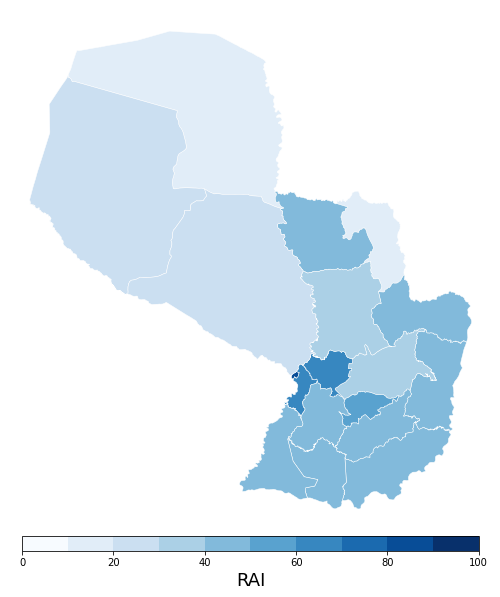

In [44]:
fig = plt.figure(figsize=(10, 10))
ax = plt.gca()
rai_df.plot(
    column='rai',
    cmap=plt.cm.get_cmap('Blues', 10),
    norm=colors.Normalize(vmin=0, vmax=100),
    edgecolor='white',
    linewidth=.5,
    ax=ax,
    legend=True,
    legend_kwds={
        'orientation': 'horizontal',
        'fraction': .028,
        'pad': 0.005,
        'aspect': 30
    })
plt.axis('off')
cax = fig.axes[1]
cax.set_xlabel('RAI', fontsize=18)
plt.show()

In [45]:
out_img_path = f"data/{code}/{pfix}_region_rai.png"
fig.savefig(out_img_path, bbox_inches='tight', pad_inches=0.)

In [ ]:
# rai_df.to_file(f"data/{code}/{code}_rai_adm1.json", driver="GeoJSON")